# veloVI-based analysis of hematopoiesis dataset

Notebook runs the veloVI model on the hematopoiesis dataset.

## Library imports

In [1]:
import scvi

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience

import cellrank as cr
import scanpy as sc
from velovi import VELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [3]:
DATASET = "hematopoiesis"

In [4]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [5]:
terminal_states = [
    "Mon",
    "Meg",
    "Bas",
    "Ery",
]

## Data loading

In [6]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
adata_full = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed_full.h5ad")

## Run veloVI

In [7]:
## prepare model
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)

In [8]:
vae.train()

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -259.100. Signaling Trainer to stop.


In [9]:
set_output(adata, vae, n_samples=30)

## Evaluate uncertainty

In [10]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=50)

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.war

In [11]:
adata.obs["veloVI intrinsic uncertainty"] = np.log10(uncertainty_df["directional_cosine_sim_variance"].values + 1e-6)

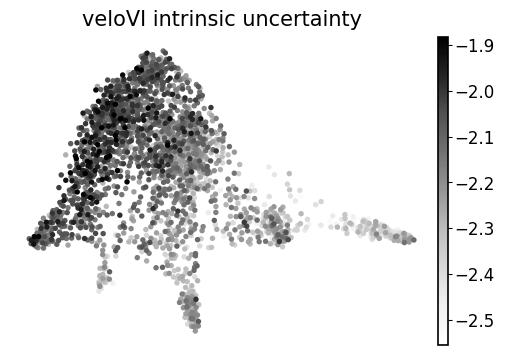

In [12]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.embedding(
        adata,
        color="veloVI intrinsic uncertainty",
        cmap="Greys",
        basis="draw_graph_fa",
        vmin="p1",
        vmax="p99",
        ax=ax,
        frameon=False,
    )

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / DATASET / "vi_uncertainty.svg", format="svg", transparent=True, bbox_inches="tight")

In [13]:
uncertainty = pd.DataFrame({"uncertainty": uncertainty_df["directional_cosine_sim_variance"].values})

## Calculate lineage fate probabilities and identify fate-associated genes

In [14]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
estimator = cr.estimators.GPCCA(vk)  ## We used vk here due to we want to benchmark on velocity

estimator.compute_macrostates(n_states=5, cluster_key="cell_type")
estimator.set_terminal_states(terminal_states)

estimator.compute_fate_probabilities()
estimator.adata = adata_full.copy()
vi_ranking = estimator.compute_lineage_drivers(return_drivers=True, cluster_key="cell_type")

vi_ranking = vi_ranking.loc[:, ["Ery_corr", "Mon_corr", "Ery_pval", "Mon_pval"]]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `value.index does not match parent’s var names:
Index are different

Index length are different
[left]:  2000, Index(['DPM1', 'GCLC', 'NFYA', 'ANKIB1', 'LASP1', 'ALS2', 'CFLAR', 'AK2',
       'RBM6', 'SLC25A13',
       ...
       'HERC2P2', 'STAG3L2', 'PMS2P14', 'PSMB3', 'DDX52', 'MYO19', 'PMS2P2',
       'ACACA', 'MRPL45', 'WASH9P'],
      dtype='object', length=2000)
[right]: 159, Index(['ADCY6', 'ALS2', 'ANKRD36C', 'ANXA1', 'ARHGAP11A', 'ARHGAP30', 'ARID5B',
       'ASPM', 'ATF6', 'BACE2',
       ...
       'UFL1', 'VASH1', 'VIM', 'VWF', 'ZEB1', 'ZFHX3', 'ZFPM1', 'ZNF263',
       'ZNF274', 'ZYX'],
      dtype='object', length=159)`


## Save dataset

Recalculate PCA for downstream CBC computation, as velocity is derived from the moment matrices.

In [15]:
sc.tl.pca(adata, layer="Ms")

Save adata with velocity layer

In [16]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_velovi.h5ad")

Save uncertainty and gene ranking results

In [17]:
if SAVE_DATA:
    uncertainty.to_csv(DATA_DIR / DATASET / "results" / "uncertainty_vi.csv")
    vi_ranking.to_csv(DATA_DIR / DATASET / "results" / "vi_ranking.csv")